In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier, SGDRegressor
import lightgbm as lgb
from matplotlib import pyplot as plt
import joblib
from pathlib import Path
import sqlite3

In [11]:
pd.options.display.max_rows=650

In [12]:
connection = sqlite3.connect('../data/nba.db')


df = pd.read_sql('SELECT * FROM team_stats_ewa_matchup_prod', con=connection)
df = df.drop(columns=['index'])

connection.close()

df = df.sort_values('GAME_DATE')

df = df.dropna()

columns_to_drop = ['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP',
                     'HOME_HOME_GAME', 'HOME_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
                     'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF',
                     'HOME_WL', 'AWAY_ML', 'AWAY_TEAM_SCORE',
                     'HOME_PTS_L5', 'HOME_PTS_L10', 'HOME_PTS_L20',
                     'HOME_PLUS_MINUS_L5', 'HOME_PLUS_MINUS_L10', 'HOME_PLUS_MINUS_L20',
                     'HOME_NET_RATING_L5', 'HOME_NET_RATING_L10', 'HOME_NET_RATING_L20',
                     'HOME_POSS_L5', 'HOME_POSS_L10', 'HOME_POSS_L20',
                     'HOME_PTS_opp_L5', 'HOME_PTS_opp_L10', 'HOME_PTS_opp_L20',
                     'HOME_PLUS_MINUS_opp_L5', 'HOME_PLUS_MINUS_opp_L10', 'HOME_PLUS_MINUS_opp_L20',
                     'HOME_NET_RATING_opp_L5', 'HOME_NET_RATING_opp_L10', 'HOME_NET_RATING_opp_L20',
                     'HOME_POSS_opp_L5', 'HOME_POSS_opp_L10', 'HOME_POSS_opp_L20',
                     'HOME_REB_L5', 'HOME_REB_L10', 'HOME_REB_L20',  
                     'HOME_REB_opp_L5', 'HOME_REB_opp_L10', 'HOME_REB_opp_L20',       
                     'AWAY_PTS_L5', 'AWAY_PTS_L10', 'AWAY_PTS_L20',
                     'AWAY_PLUS_MINUS_L5', 'AWAY_PLUS_MINUS_L10', 'AWAY_PLUS_MINUS_L20',
                     'AWAY_NET_RATING_L5', 'AWAY_NET_RATING_L10', 'AWAY_NET_RATING_L20',
                     'AWAY_POSS_L5', 'AWAY_POSS_L10', 'AWAY_POSS_L20',
                     'AWAY_PTS_opp_L5', 'AWAY_PTS_opp_L10', 'AWAY_PTS_opp_L20',
                     'AWAY_PLUS_MINUS_opp_L5', 'AWAY_PLUS_MINUS_opp_L10', 'AWAY_PLUS_MINUS_opp_L20',
                     'AWAY_NET_RATING_opp_L5', 'AWAY_NET_RATING_opp_L10', 'AWAY_NET_RATING_opp_L20',
                     'AWAY_POSS_opp_L5', 'AWAY_POSS_opp_L10', 'AWAY_POSS_opp_L20',
                     'AWAY_REB_L5', 'AWAY_REB_L10', 'AWAY_REB_L20',
                     'AWAY_REB_opp_L5', 'AWAY_REB_opp_L10', 'AWAY_REB_opp_L20']

train_df = df.loc[df['SEASON'] < '2021-22']
test_df = df.loc[df['SEASON'] >= '2021-22']


X_train = train_df.drop(columns=columns_to_drop)
y_train = train_df['HOME_WL']

X_test = test_df.drop(columns=columns_to_drop)
y_test = test_df['HOME_WL']

train_df.shape, test_df.shape

((9721, 645), (1694, 645))

In [13]:
# test_df.loc[test_df['MATCHUP'].str.contains('BOS')].sort_values('GAME_DATE')

In [14]:
con = sqlite3.connect('../data/nba.db')
pd.read_sql("SELECT name FROM sqlite_schema WHERE type='table'", con)
con.close()

In [15]:
con = sqlite3.connect('../data/nba.db')
adv_boxscores = pd.read_sql("""SELECT SEASON
                                ,team_scoring_boxscores.* 
                                FROM team_scoring_boxscores
                                LEFT JOIN team_basic_boxscores
                                ON team_scoring_boxscores.GAME_ID = team_basic_boxscores.GAME_ID
                                AND team_scoring_boxscores.TEAM_ID = team_basic_boxscores.TEAM_ID
                                WHERE SEASON = '2022-23'
                                
                            """, con)
con.close()

adv_boxscores.isnull().sum()

SEASON               0
GAME_ID              0
TEAM_ID              0
TEAM_NAME            0
TEAM_ABBREVIATION    0
TEAM_CITY            0
MIN                  0
PCT_FGA_2PT          0
PCT_FGA_3PT          0
PCT_PTS_2PT          0
PCT_PTS_2PT_MR       0
PCT_PTS_3PT          0
PCT_PTS_FB           0
PCT_PTS_FT           0
PCT_PTS_OFF_TOV      0
PCT_PTS_PAINT        0
PCT_AST_2PM          0
PCT_UAST_2PM         0
PCT_AST_3PM          0
PCT_UAST_3PM         0
PCT_AST_FGM          0
PCT_UAST_FGM         0
dtype: int64

In [16]:
pd.read_sql("""SELECT * FROM team_advanced_boxscores
                limit 1""", con)

ProgrammingError: Cannot operate on a closed database.

In [ ]:
test = pd.read_sql("""SELECT * FROM team_basic_boxscores a
                LEFT JOIN team_advanced_boxscores b
                ON a.GAME_ID = b.GAME_ID
                AND a.TEAM_ID = b.TEAM_ID
                LEFT JOIN team_scoring_boxscores c
                ON a.GAME_ID = c.GAME_ID
                AND a.TEAM_ID = c.TEAM_ID
                LEFT JOIN team_tracking_boxscores d
                ON a.GAME_ID = d.GAME_ID
                AND a.TEAM_ID = d.TEAM_ID                
                WHERE SEASON = '2022-23'
                """, con)



In [ ]:
test.loc[test.isnull().any(axis=1)].T

,888,890
SEASON,2022-23,2022-23
TEAM_ID,1610612753,1610612738
TEAM_ABBREVIATION,ORL,BOS
TEAM_NAME,Orlando Magic,Boston Celtics
GAME_ID,0022200445,0022200445
GAME_DATE,2022-12-18,2022-12-18
MATCHUP,ORL @ BOS,BOS vs. ORL
WL,W,L
MIN,240,240
FGM,33,31


In [ ]:
pd.read_sql("""SELECT * FROM team_scoring_boxscores
                WHERE GAME_ID = '0022200445'""", con)

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,...,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM
0,0022200445,1610612753,Magic,ORL,Orlando,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0022200445,1610612738,Celtics,BOS,Boston,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0022200445,1610612753,Magic,ORL,Orlando,240:00,0.663,0.337,0.442,0.105,...,0.095,0.179,0.137,0.337,0.476,0.524,0.833,0.167,0.606,0.394
3,0022200445,1610612738,Celtics,BOS,Boston,240:00,0.472,0.528,0.413,0.043,...,0.217,0.196,0.087,0.370,0.526,0.474,1.000,0.000,0.710,0.290


In [ ]:
from nba_api.stats.endpoints import boxscorescoringv2
boxscores = boxscorescoringv2.BoxScoreScoringV2(game_id='0022200445').get_data_frames()[1]
boxscores

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,...,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM
0,0022200445,1610612753,Magic,ORL,Orlando,240:00,0.663,0.337,0.442,0.105,...,0.095,0.179,0.137,0.337,0.476,0.524,0.833,0.167,0.606,0.394
1,0022200445,1610612738,Celtics,BOS,Boston,240:00,0.472,0.528,0.413,0.043,...,0.217,0.196,0.087,0.370,0.526,0.474,1.000,0.000,0.710,0.290


In [17]:
def view_model_coefs(model, X_train, plot_graph = True, remove_zero_coefs=True):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})
    if remove_zero_coefs:
        coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    if plot_graph:
        top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
        top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df

In [18]:
filename = 'SGDRegressor_ScorePredictor.sav'
model_location = Path.home().joinpath('NBA_model_v1', 'models', filename)

best_sgd_reg = joblib.load(model_location)


In [19]:
filename = 'LGBRegressor.sav'
model_location = Path.home().joinpath('NBA_model_v1', 'models', filename)

best_lgb_reg = joblib.load(model_location)

In [20]:
best_sgd_reg.named_steps['sgd'].estimators_[0].coef_

array([ 2.79291811e+00, -3.50707014e-01,  1.05138805e-02,  4.97696381e-01,
        5.49926747e-01, -6.14240856e-02,  1.18410798e-01, -1.47929629e-01,
       -2.82707349e-01, -2.44462760e-02,  3.54146358e-01, -1.15406263e-01,
       -6.35602949e-02, -2.34661346e-01,  1.20985469e-01,  4.38092464e-02,
       -1.40865079e-01,  1.05180590e-02,  1.89793628e-01,  1.36739919e-01,
       -1.75620463e-01, -1.34705418e-01, -1.53040442e-01, -1.76723993e-01,
       -1.88060959e-01,  7.05014097e-02, -5.40492850e-01,  3.43914806e-01,
        3.43243407e-01, -1.17466228e-01, -2.49839377e-01, -2.36546212e-01,
        1.91447872e-02, -5.00196210e-01, -2.12907188e-01,  4.69691603e-02,
       -5.95568455e-01, -1.23581936e-01, -3.50465983e-01, -4.89689832e-02,
        1.35831425e-02, -1.12846626e-01, -2.03658798e-01, -2.28725913e-02,
       -1.48698949e-01, -1.06324860e-01,  5.34982017e-02, -1.09376235e-01,
       -5.51481677e-02, -2.16798247e-03, -4.43934264e-02, -1.21858038e-02,
        1.20985469e-01, -

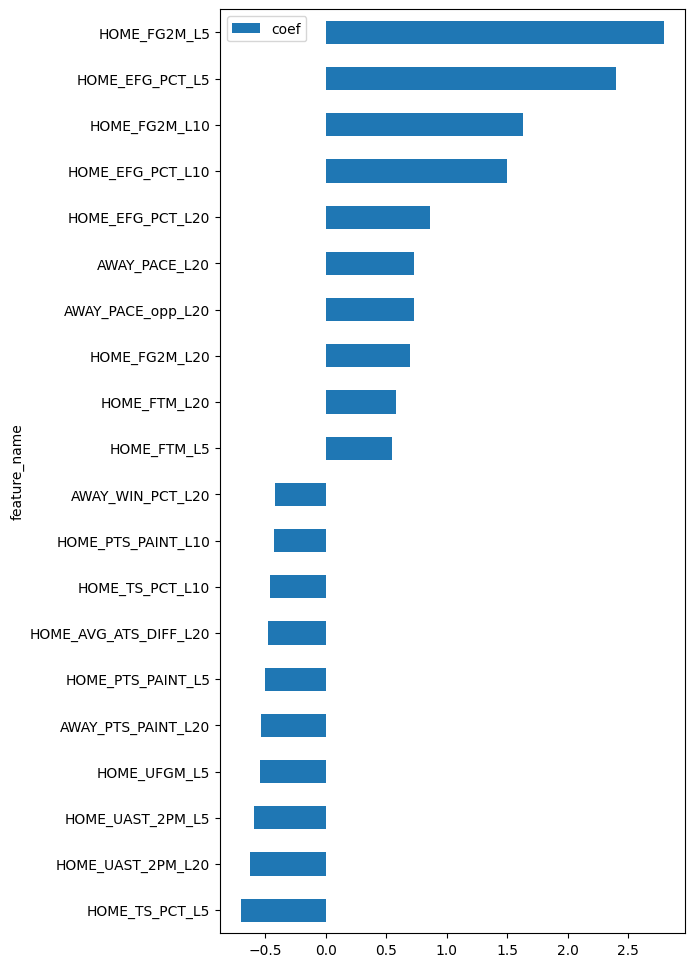

In [21]:
sgd_coef_df = view_model_coefs(best_sgd_reg.named_steps['sgd'].estimators_[0], X_train)

In [10]:
sgd_coef_df.sort_values(['coef'], ascending=False)

,feature_name,coef
0,HOME_FG2M_L5,2.776473
87,HOME_EFG_PCT_L5,2.409453
94,HOME_FG2M_L10,1.635541
181,HOME_EFG_PCT_L10,1.494109
275,HOME_EFG_PCT_L20,0.863440
527,AWAY_PACE_opp_L20,0.717559
488,AWAY_PACE_L20,0.717559
188,HOME_FG2M_L20,0.701500
192,HOME_FTM_L20,0.585336
4,HOME_FTM_L5,0.575426


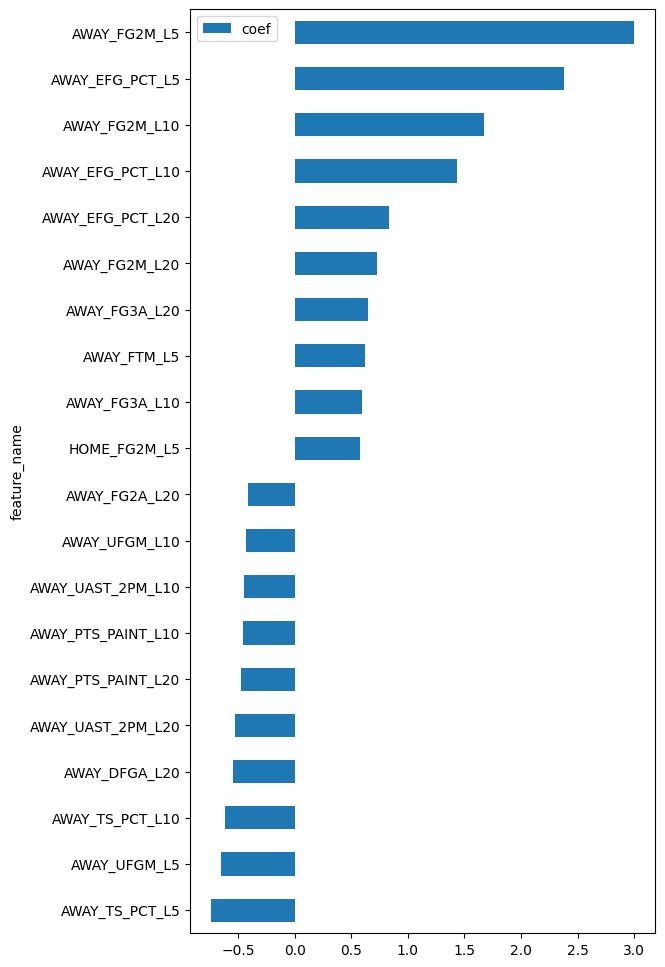

In [21]:
sgd_coef_df = view_model_coefs(best_sgd_reg.named_steps['sgd'].estimators_[1], X_train)

,feature_name,coef
77,HOME_WIN_PCT_L5,0.043270
265,HOME_WIN_PCT_L20,-0.187209
171,HOME_WIN_PCT_L10,-0.218156
65,HOME_UFGM_opp_L5,-0.085541
253,HOME_UFGM_opp_L20,-0.090771
159,HOME_UFGM_opp_L10,-0.128072
26,HOME_UFGM_L5,-0.227882
214,HOME_UFGM_L20,-0.081637
120,HOME_UFGM_L10,-0.175337
66,HOME_UFGA_opp_L5,0.047581


LGBoost or XGBoost


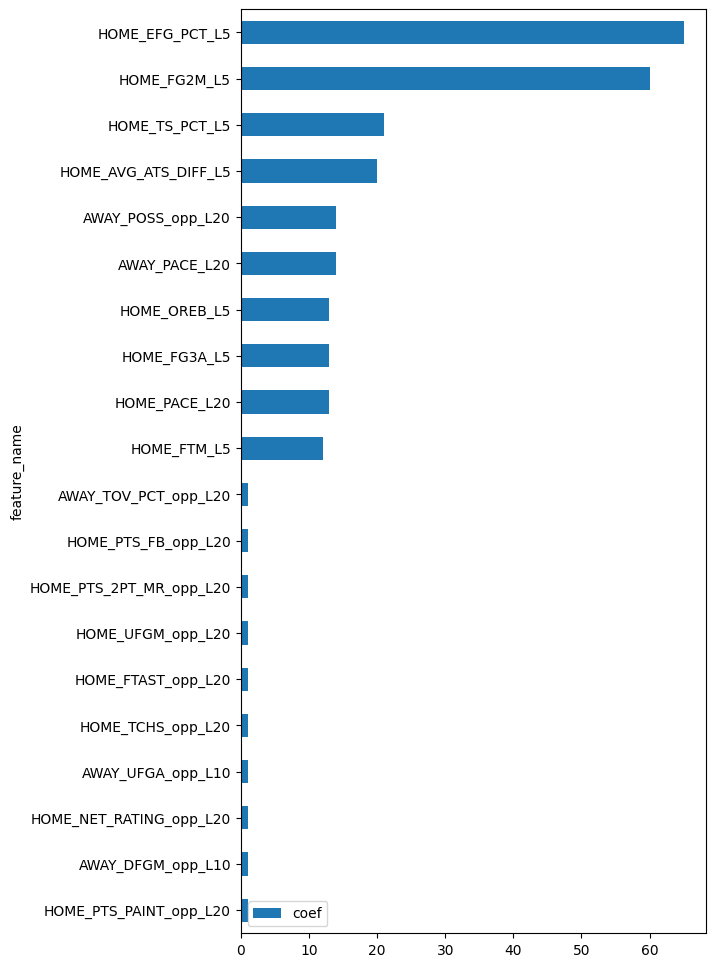

In [13]:
lgb_coef_df = view_model_coefs(best_lgb_reg.estimators_[0], X_train)

LGBoost or XGBoost


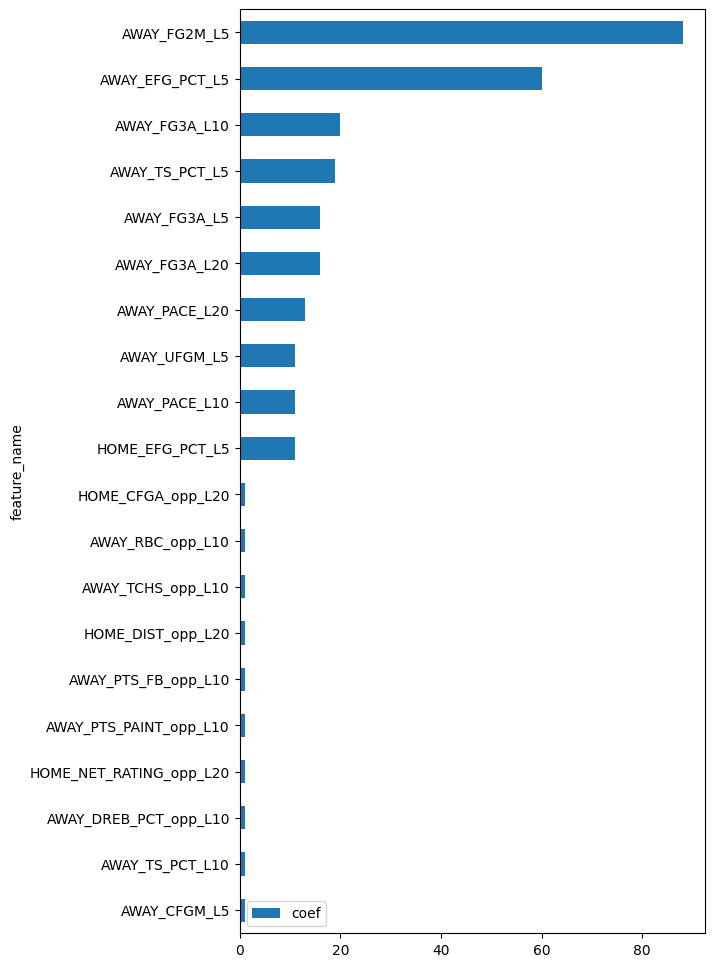

In [14]:
lgb_coef_df = view_model_coefs(best_lgb_reg.estimators_[1], X_train)